In [2]:
'''2024 Feb Copy from Feb2023datagenerator_SNR_Vol.ipynb, testing data with PUs of different modulation
Feb 2024, added data_generator_RandMod
 one channel per logit version, multiple SNR or multiple volumn
'''
import csv
#import numpy as np
from numpy.random import RandomState
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
#import random

import torch
#torch.cuda.set_device(0)
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import math
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.distributed as TUDdistributed
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
from scipy import signal
import datetime
import shutil
from pytz import timezone
import time
TMZ = timezone('EST')

device = torch.device("cuda")
#use_cuda = True
criterion = nn.CrossEntropyLoss()


def avg_signal_pw(assign_dict, beta, alpha, nPU, nSU, nch, DistAmp):
  #calculate average signal power per freq_pt
  #
  total_pw = 0
  for SU in range(nSU):
    for PU in range(nPU):
      total_pw=total_pw+len(assign_dict['PU'+str(PU)])*(beta*((DistAmp*dist_dict[PU][SU])**alpha))**(-1)

  avg_pw = total_pw/(nSU*nch)
  print(avg_pw)
  return avg_pw

PU 0 :  [1.1547005383792515, 1.1547005383792515, 2.309401076758503, 3.0550504633038935, 4.163331998932265, 2.309401076758503, 3.055050463303893, 3.055050463303893, 4.163331998932265, 4.618802153517006]
PU 1 :  [2.309401076758503, 1.1547005383792515, 1.1547005383792515, 1.1547005383792515, 2.309401076758503, 3.055050463303893, 3.055050463303893, 2.309401076758503, 3.055050463303893, 3.055050463303893]
PU 2 :  [4.163331998932265, 3.0550504633038935, 2.309401076758503, 1.1547005383792515, 1.1547005383792515, 4.618802153517006, 4.163331998932265, 3.055050463303893, 3.055050463303893, 2.309401076758503]
PU 3 :  [1.1547005383792515, 2.309401076758503, 3.0550504633038935, 4.163331998932265, 5.033222956847166, 1.1547005383792515, 2.309401076758503, 3.0550504633038935, 4.163331998932265, 5.033222956847166]
PU 4 :  [1.1547005383792515, 1.1547005383792515, 1.1547005383792515, 2.309401076758503, 3.0550504633038935, 1.1547005383792515, 1.1547005383792515, 1.1547005383792515, 2.309401076758503, 3.05

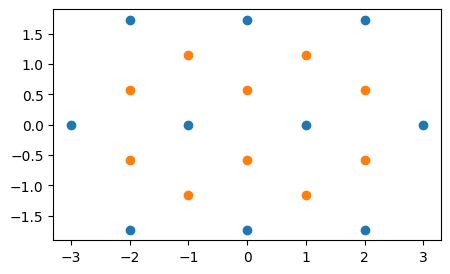

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# only need to amplify distance dict/list. no need to 
locat_endpt = { # location of 10 pts, regular triangle side-length=2 mode
   0: [-2, 3**.5], 
   1: [0, 3**.5],
   2: [2, 3**.5],
   3: [-3, 0],
   4: [-1, 0],
   5: [1, 0],
   6: [3, 0],
   7: [-2, -3**.5],
   8: [0, -3**.5],
   9: [2, -3**.5],
}

locat_centre = { # location of 10pts, centre of regular traingles with sinde-length=2
    0: [-2, 3**.5/3],
    1: [-1, 2/3*3**.5],
    2: [0, 3**.5/3],
    3: [1, 2/3*3**.5],
    4: [2, 3**.5/3],
    5: [-2, -3**.5/3],
    6: [-1, -2/3*3**.5],
    7: [0, -3**.5/3],
    8: [1, -2/3*3**.5],
    9: [2, -3**.5/3],
}
x = [locat_endpt[i][0] for i in range(10)]
x1 = [locat_centre[i][0] for i in range(10)]
y = [locat_endpt[i][1] for i in range(10)]
y1 = [locat_centre[i][1] for i in range(10)]
# print(x)
# print(y)
plt.figure(figsize=(5, 3))
plt.scatter(x,y)
plt.scatter(x1,y1)
plt.show
# plt.plot()
# dist_dict = {i:[dist_ori[(j-i)%10]+(random.random()*0.8-0.4)*disAmp for j in range(nnode)] for i in range(nch)}
'''First assume that PUs at locat_endpt, SUs at locat_centre'''
dist_dict = {i: [np.linalg.norm( np.array(locat_endpt[i])-np.array(locat_centre[j]) ) for j in range(len(locat_centre))] for i in range(len(locat_endpt))} #nch(or PU, exactly): distance to each SU. 
dist_dict1 = {i: [np.linalg.norm( np.array(locat_centre[i])-np.array(locat_endpt[j]) ) for j in range(len(locat_endpt))] for i in range(len(locat_centre))} #SU at endpt, PU at center case
for i in range(len(dist_dict)):
  print('PU',i,': ', dist_dict[i])
# print(dist_dict)

In [5]:
assign_dict10 = { 
    'description': 'The bands allocated to each PU. for 10-band-case',
    'nPU': 10,
    'PU0':[0],
    'PU1':[1],
    'PU2':[2],
    'PU3':[3],
    'PU4':[4],
    'PU5':[5],
    'PU6':[6],
    'PU7':[7],
    'PU8':[8],
    'PU9':[9],
}

class_dir10 = [
    [0,3,4], 
    [0,1,4],
    [1,4,5],
    [1,2,5],
    [2,5,6],
    [3,4,7],
    [4,7,8],
    [4,5,8],
    [5,8,9],
    [5,6,9]
]

assign_dict20 = { 
    'description': 'The bands allocated to each PU. for 20-band-case, 3 single-band PUs, 4 double-band PUs, 3 triple-band PUs',
    'nPU': 10,
    'PU0':[0],
    'PU1':[1, 10],
    'PU2':[2, 11, 14],
    'PU3':[3],
    'PU4':[4, 19],
    'PU5':[5, 13],
    'PU6':[6, 15, 17],
    'PU7':[7, 12, 18],
    'PU8':[8, 16],
    'PU9':[9],
}

# class_dir_20 = [ class_dir10[SU] for SU in range(len(class_dir10))]
# for PU in class_dir10[SU]
class_dir20 = [[ ] for i in range(len(class_dir10))] #make empty classdir20
for SU in range(len(class_dir10)):
    for PU in class_dir10[SU]:
        class_dir20[SU].extend(assign_dict20['PU'+str(PU)]) 

for SU in range(len(class_dir20)):
  print('SU',SU,' observable bands: ', class_dir20[SU])

# print(class_dir20)

SU 0  observable bands:  [0, 3, 4, 19]
SU 1  observable bands:  [0, 1, 10, 4, 19]
SU 2  observable bands:  [1, 10, 4, 19, 5, 13]
SU 3  observable bands:  [1, 10, 2, 11, 14, 5, 13]
SU 4  observable bands:  [2, 11, 14, 5, 13, 6, 15, 17]
SU 5  observable bands:  [3, 4, 19, 7, 12, 18]
SU 6  observable bands:  [4, 19, 7, 12, 18, 8, 16]
SU 7  observable bands:  [4, 19, 5, 13, 8, 16]
SU 8  observable bands:  [5, 13, 8, 16, 9]
SU 9  observable bands:  [5, 13, 6, 15, 17, 9]


In [7]:
''' 
Feb 2024, added data_generator_RandMod which allow PU to use varying Mod (used for testing in revision)
Set dist to generate diff distance btw PU SU
Feb20, 2023 ver, apply 64 dim PSD from MATLAB
'''
nw = 64 # bandwidth 64 freq pts （2023）
nSU = len(class_dir20)

address = '' # 2023 Feb MATLAB data
name = 'clean_PSD_6mod_Mat.pth'
cleanPSD = torch.load(address+name) # load saved clean PSDs
#Check saved PSDs
print(cleanPSD['Description'])

def data_generator_dist(DistAmp, class_dir, dbsize_list, nch, nw, assign_dict, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154): 
    '''
    2023 version modified:

    Database for collective learning, 
    emited signals from MATLAB, 64 pts per band, 
    then apply noises and path-losses to received signals on nodes
    '''
    label_list =[] # label list of training data
    db = [] # dataset (list)
    nPU = assign_dict['nPU'] #num of PUs
    # Calculating noise_pw based on dist_dict
    # DistAmp = 10 #if 1, regular triangular side-length=2 # Distance Amplifier

    nSU = len(class_dir)
    avg_pw = avg_signal_pw(assign_dict, beta, alpha, nPU, nSU, nch, DistAmp) #avg_power/freq_pt
    noi_pw = avg_pw*10**(-1*SNR/10)

    for cls in range(2**nPU): #for every occupation condition       # idx of occupation class 
        for n in range( dbsize_list[cls] ):#repeat for all samples in this class     
            inp = []   # a list of input tensors of all nodes           
            label = torch.zeros(nch)
            PSDidx = [random.randrange(10) for k in range(nPU)] # fixed PSD for certain PU 
            for SU in range(len(class_dir)): # a set of node-received data
                a = torch.randn(1,nw,nch) * noi_pw # new 2023Feb local noise
                
                for PU in range(nPU): # for each channel
                    if cls & (2**(PU)) : #find active PU for this cls  
                             #print('occupied channel',ch)
                        ch_gain=(beta * ((DistAmp*dist_dict[PU][SU])**alpha))**(-1)# To be updated
                        ch_gain=ch_gain*10**(-0.365*torch.randn(1).item()) #shadow fading
                        for ch in assign_dict['PU'+str(PU)]:
                            label[ch] = 1
                            #apply clean signal
                            rcv_sig = PSD_lib[PU%6+1][PSDidx[PU]]
                            pw = sum(rcv_sig[64:128])/64
                            rcv_sig = rcv_sig/pw * ch_gain #unit power per freq pts and apply channel gain
                            '''False to normalize after pathloss
                            Pathloss model to be reviewed
                            Average SNR to be plug-in'''
                            a[0,:,ch].add_(torch.tensor(rcv_sig[64:128])[:,0]) # Apply Path-loss # Use [:,0] to convert [192,1] to [192]
                            if ch > 0: #cls not left most
                                a[0, :, ch-1].add_(torch.tensor(rcv_sig[0:64] )[:,0]) #apply leakage to left neighbor channel
                            if ch < (nch-1):  #cls not right most
                                a[0, :, ch+1].add_(torch.tensor(rcv_sig[-64:192] )[:,0]) #apply leakage to right neighbor channel

                inp.append(torch.abs(a))        

            db.append(deepcopy(inp))  # add to dataset list      
            label_list.append(deepcopy(label))  # add label to list
    return db, label_list #, noi

def data_generator_RandMod(DistAmp, class_dir, dbsize_list, nch, nw, assign_dict, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154): 
    '''
    2024 modified for random PU modulation:

    '''
    label_list =[] # label list of training data
    db = [] # dataset (list)
    nPU = assign_dict['nPU'] #num of PUs
    # Calculating noise_pw based on dist_dict
    # DistAmp = 10 #if 1, regular triangular side-length=2 # Distance Amplifier

    nSU = len(class_dir)
    avg_pw = avg_signal_pw(assign_dict, beta, alpha, nPU, nSU, nch, DistAmp) #avg_power/freq_pt
    noi_pw = avg_pw*10**(-1*SNR/10)

    for cls in range(2**nPU): #for every occupation condition       # idx of occupation class 
        for n in range( dbsize_list[cls] ):#repeat for all samples in this class     
            inp = []   # a list of input tensors of all nodes           
            label = torch.zeros(nch)
            PSDidx = [random.randrange(10) for k in range(nPU)] # fixed PSD for certain PU 
            for SU in range(len(class_dir)): # a set of node-received data
                a = torch.randn(1,nw,nch) * noi_pw # new 2023Feb local noise
                
                for PU in range(nPU): # for each channel
                    if cls & (2**(PU)) : #find active PU for this cls  
                             #print('occupied channel',ch)
                        ch_gain=(beta * ((DistAmp*dist_dict[PU][SU])**alpha))**(-1)# To be updated
                        ch_gain=ch_gain*10**(-0.365*torch.randn(1).item()) #shadow fading
                        Mod_idx = random.randrange(6)+1 #random mod 4 this PU
                        for ch in assign_dict['PU'+str(PU)]:
                            label[ch] = 1
                            #apply clean signal
                            rcv_sig = PSD_lib[Mod_idx][PSDidx[PU]] # random Mod but chosen PSD
                            pw = sum(rcv_sig[64:128])/64
                            rcv_sig = rcv_sig/pw * ch_gain #unit power per freq pts and apply channel gain
                            '''False to normalize after pathloss
                            Pathloss model to be reviewed
                            Average SNR to be plug-in'''
                            a[0,:,ch].add_(torch.tensor(rcv_sig[64:128])[:,0]) # Apply Path-loss # Use [:,0] to convert [192,1] to [192]
                            if ch > 0: #cls not left most
                                a[0, :, ch-1].add_(torch.tensor(rcv_sig[0:64] )[:,0]) #apply leakage to left neighbor channel
                            if ch < (nch-1):  #cls not right most
                                a[0, :, ch+1].add_(torch.tensor(rcv_sig[-64:192] )[:,0]) #apply leakage to right neighbor channel

                inp.append(torch.abs(a))        

            db.append(deepcopy(inp))  # add to dataset list      
            label_list.append(deepcopy(label))  # add label to list
    return db, label_list #, noi


def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    shutil.rmtree(filepath, ignore_errors = True)
    os.makedirs(filepath)

from Matlab, PSD of 6 narrowband sig (4 PSKs, FSK, QAM), length =64, type is 1D numpy ndarray tensor. each key has a list of 10 set 192-dim PSDs


In [8]:
'''2024Spr Ver: Random PU mod data for diff training/testing
20/ocp Tr; 5/ocp Te, can set PU SU distences and alpha values
Generate and save dataset under multiple SNR'''
time_start=time.time()
nch=20
nPU = assign_dict20['nPU']
ncls = 2**nPU
DistAmp = 10 # 25
alpha = 3.71 #3.71
volumn = (20, 5) #Only want testing volumn/ocp for (training and testing)  (20, 1)  (10, 1)
dbsize_list = [volumn[0] for i in range(ncls)] # size of train data in each class
'''Generan Training data, will be saved later'''
# for SNR in range(11):
# address1 = 'RefinedNewData/SNRs/'+str(DistAmp)+'m_Alpha'+str(alpha)+'/'
address1 = 'RefinedNewData/SNRs/RandMod/'
now =datetime.datetime.now()
time_watermark = now.strftime('%y%m%d_%H_%M')
save_dir=address1+time_watermark+'/'
setDir(save_dir)

for snr in [10, 12, 14, 16]: #[0, 2, 4, 6, 8, 10, 12, 14, 16][8]: #[4, 8, 12, 16]:[ 4, 8, 12, 16, 20, 0]
    SNR=-1*snr
    datas_tr, labels_tr = data_generator_RandMod(DistAmp, class_dir20, dbsize_list, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha = 3.71, beta = 10**3.154)
    time_end=time.time()
    '''testing set'''
    dbsize_list_te = [volumn[1] for i in range(ncls)] # size of test data in each class

    datas_te, labels_te= data_generator_RandMod(DistAmp, class_dir20, dbsize_list_te, nch, nw, assign_dict20, SNR, dist_dict, PSD_lib=cleanPSD, alpha=alpha, beta = 10**3.154)

    '''data saving'''

    db = {
        'Description': 'cleanPSD64.pth, SNR'+str(SNR)+'dB, '+str(nch)+'bands/PUs, '+'64 pts/band.',
        'training data list': datas_tr,
        'training label list': labels_tr,
        'testing data list': datas_te,
        'testing label list': labels_te,
        'time':'TBD',
        'classdir': class_dir20,
    }

    name1 = 'Data_SNR'+str(SNR)+'vol'+str(volumn[0])+'.pth' #W/O time watermark child dir
    db['time'] = time_watermark # apply watermark to db dict
    torch.save(db, save_dir + name1)
    print('dataset saved to: '+save_dir + name1)

    time_end=time.time()
    print('time cost',time_end-time_start,'s')    

2.6134768430854433e-08


2.6134768430854433e-08
dataset saved to: RefinedNewData/SNRs/RandMod/240208_23_35/Data_SNR-10vol20.pth
time cost 137.70493602752686 s
2.6134768430854433e-08
2.6134768430854433e-08
dataset saved to: RefinedNewData/SNRs/RandMod/240208_23_35/Data_SNR-12vol20.pth
time cost 274.20370531082153 s
2.6134768430854433e-08
2.6134768430854433e-08
dataset saved to: RefinedNewData/SNRs/RandMod/240208_23_35/Data_SNR-14vol20.pth
time cost 409.6185600757599 s
2.6134768430854433e-08
2.6134768430854433e-08
dataset saved to: RefinedNewData/SNRs/RandMod/240208_23_35/Data_SNR-16vol20.pth
time cost 545.9798579216003 s
